## This tutorial is originally written by corazzon, https://github.com/corazzon/OpenDataWrangling/blob/master/park.ipynb, with some edition by myself.

<ul><li>It visualizes distribution of parks in South Korea.</li></ul>

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
import pandas as pd
import numpy as np
from plotnine import *
import re

import folium

In [40]:
park = pd.read_csv('data/전국도시공원표준데이터.csv', encoding='euc-kr')
park.shape

(16096, 20)

In [41]:
park.head(4)

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,제공기관코드,제공기관명,Unnamed: 19
0,29170-00001,문화근린공원,근린공원,광주광역시 북구 대천로 86,광주광역시 북구 문흥동 1009-1,35.184917,126.916686,87710.3,NaN,NaN,NaN,NaN,NaN,1990-12-31,광주광역시 북구청,062-410-6438,2018-04-17,3620000,광주광역시 북구,NaN
1,29170-00002,두암제1근린공원,근린공원,광주광역시 북구 삼정로 36,광주광역시 북구 두암동 969-4,35.165104,126.937650,13383.5,NaN,NaN,NaN,NaN,NaN,1990-12-12,광주광역시 북구청,062-410-6438,2018-04-17,3620000,광주광역시 북구,NaN
2,29170-00003,첨단체육근린공원,근린공원,광주광역시 북구 임방울대로 877,광주광역시 북구 오룡동 1113,35.220546,126.858765,170920.6,NaN,NaN,NaN,NaN,NaN,1991-12-12,광주광역시 북구청,062-410-6438,2018-04-17,3620000,광주광역시 북구,NaN
3,29170-00004,일곡제1근린공원,근린공원,광주광역시 북구 일곡로 55,광주광역시 북구 일곡동 850-1,35.207975,126.895445,34840.3,NaN,NaN,NaN,NaN,NaN,1993-12-06,광주광역시 북구청,062-410-6438,2018-04-17,3620000,광주광역시 북구,NaN


In [42]:
park.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16096 entries, 0 to 16095
Data columns (total 20 columns):
관리번호            16096 non-null object
공원명             16096 non-null object
공원구분            16096 non-null object
소재지도로명주소        8321 non-null object
소재지지번주소         15213 non-null object
위도              16096 non-null float64
경도              16096 non-null float64
공원면적            16096 non-null float64
공원보유시설(운동시설)    4164 non-null object
공원보유시설(유희시설)    6085 non-null object
공원보유시설(편익시설)    4344 non-null object
공원보유시설(교양시설)    914 non-null object
공원보유시설(기타시설)    2503 non-null object
지정고시일           13512 non-null object
관리기관명           15381 non-null object
전화번호            14966 non-null object
데이터기준일자         16096 non-null object
제공기관코드          16096 non-null object
제공기관명           16096 non-null object
Unnamed: 19     0 non-null float64
dtypes: float64(4), object(16)
memory usage: 2.5+ MB


In [43]:
park.isnull().sum()

관리번호                0
공원명                 0
공원구분                0
소재지도로명주소         7775
소재지지번주소           883
위도                  0
경도                  0
공원면적                0
공원보유시설(운동시설)    11932
공원보유시설(유희시설)    10011
공원보유시설(편익시설)    11752
공원보유시설(교양시설)    15182
공원보유시설(기타시설)    13593
지정고시일            2584
관리기관명             715
전화번호             1130
데이터기준일자             0
제공기관코드              0
제공기관명               0
Unnamed: 19     16096
dtype: int64

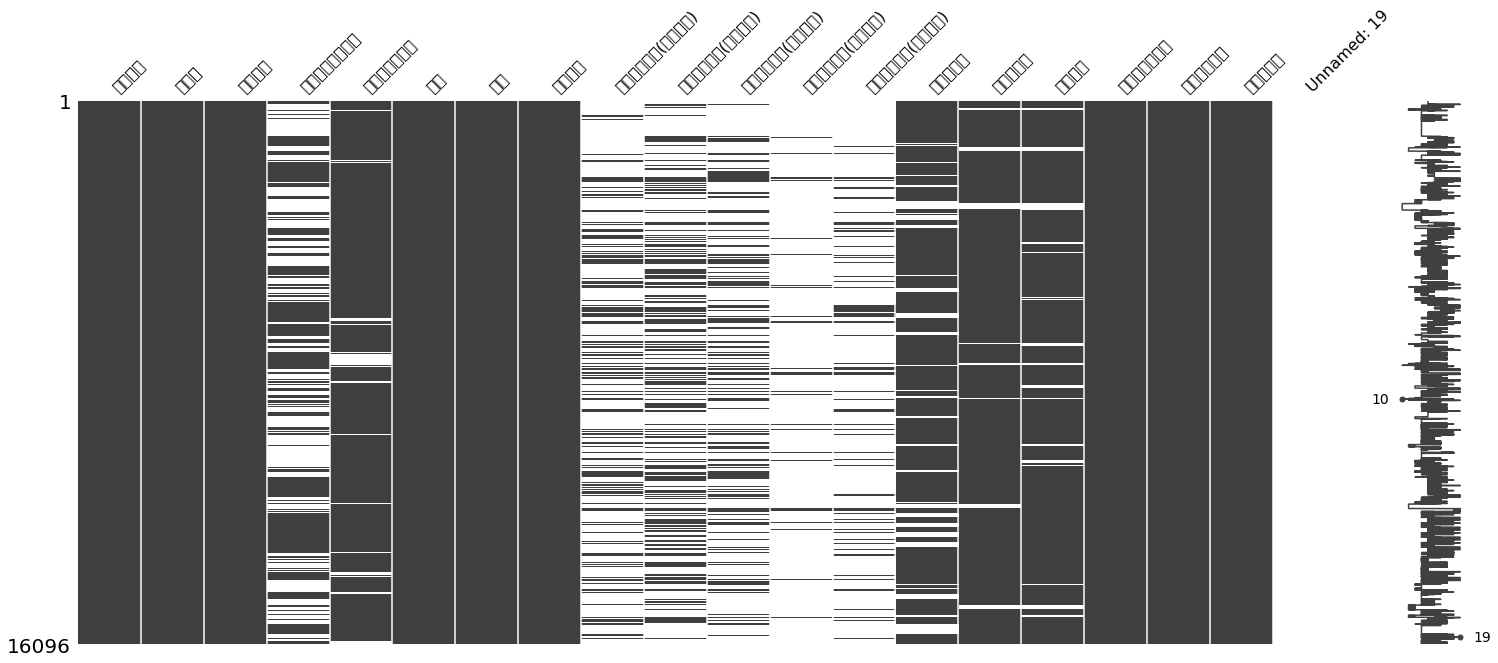

In [44]:
import missingno as msno
msno.matrix(park)

In [45]:
park.columns

Index(['관리번호', '공원명', '공원구분', '소재지도로명주소', '소재지지번주소', '위도', '경도', '공원면적',
       '공원보유시설(운동시설)', '공원보유시설(유희시설)', '공원보유시설(편익시설)', '공원보유시설(교양시설)',
       '공원보유시설(기타시설)', '지정고시일', '관리기관명', '전화번호', '데이터기준일자', '제공기관코드', '제공기관명',
       'Unnamed: 19'],
      dtype='object')

Column names are broken due to font issue.
There are some columns not needed for this analysis, so let's drom them.

In [46]:
park.drop(columns=['공원보유시설(운동시설)', '공원보유시설(유희시설)', '공원보유시설(편익시설)', '공원보유시설(교양시설)',
       '공원보유시설(기타시설)', '지정고시일', '관리기관명', 'Unnamed: 19'], inplace=True)

In [47]:
park.shape

(16096, 12)

# Visualizes Latitude/longitude

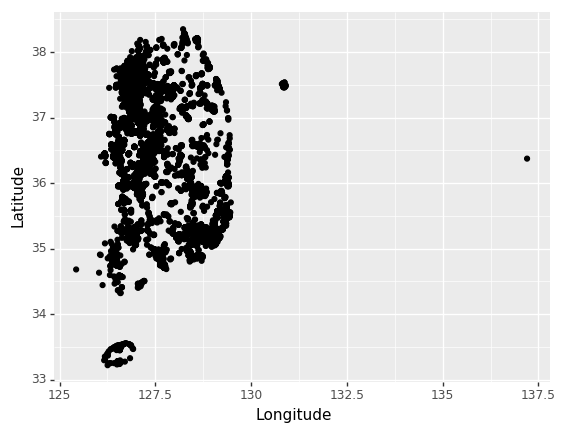

<ggplot: (-9223372006354906680)>

In [48]:
(ggplot(park) + aes(x='경도', y='위도') + geom_point() + labs(x="Longitude", y="Latitude"))


# Data Cleaning
<ul>
    <li>Replace to other address if either of addresses is missing</li>
    <li>Remove outliers (out of S.korean territory)</li>
</ul>

## Adjust data to plotable no.

In [49]:
park.dtypes

관리번호         object
공원명          object
공원구분         object
소재지도로명주소     object
소재지지번주소      object
위도          float64
경도          float64
공원면적        float64
전화번호         object
데이터기준일자      object
제공기관코드       object
제공기관명        object
dtype: object

In [50]:
park['공원면적'].head()

0     87710.3
1     13383.5
2    170920.6
3     34840.3
4     10315.0
Name: 공원면적, dtype: float64

Since the sizes are in too big numbers to plot, adjust them.

In [51]:
park['size ratio'] = park['공원면적'].apply(lambda x : np.sqrt(x)*0.01)
park['size ratio'].head()

0    2.961592
1    1.156871
2    4.134254
3    1.866556
4    1.015628
Name: size ratio, dtype: float64

## Address adjustment

In [52]:
# address type 1
park['소재지도로명주소'].isnull().sum()

7775

In [53]:
# address type 2
park['소재지지번주소'].isnull().sum()

883

In [54]:
park.loc[(park['소재지도로명주소'].isnull()) & (park['소재지지번주소'].notnull())].shape

(7775, 13)

In [55]:
park['소재지도로명주소'].fillna(park['소재지지번주소'], inplace = True)

In [56]:
park['소재지도로명주소'].isnull().sum()

0

In [57]:
park_loc = park.loc[(park['소재지도로명주소'].isnull()) & (park['소재지지번주소'].notnull())]
park_loc.shape

(0, 13)

## Categorize locations
!note: Korean address is larger to smaller (e.g. province, city, gu, apt.name, #th floor, room %%)

In [58]:
park['City/Province'] = park['소재지도로명주소'].str.split(' ', expand=True)[0]
park.head(3)

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,제공기관코드,제공기관명,size ratio,City/Province
0,29170-00001,문화근린공원,근린공원,광주광역시 북구 대천로 86,광주광역시 북구 문흥동 1009-1,35.184917,126.916686,87710.3,062-410-6438,2018-04-17,3620000,광주광역시 북구,2.961592,광주광역시
1,29170-00002,두암제1근린공원,근린공원,광주광역시 북구 삼정로 36,광주광역시 북구 두암동 969-4,35.165104,126.937650,13383.5,062-410-6438,2018-04-17,3620000,광주광역시 북구,1.156871,광주광역시
2,29170-00003,첨단체육근린공원,근린공원,광주광역시 북구 임방울대로 877,광주광역시 북구 오룡동 1113,35.220546,126.858765,170920.6,062-410-6438,2018-04-17,3620000,광주광역시 북구,4.134254,광주광역시


In [59]:
park['Gu/Gun'] = park['소재지도로명주소'].str.split(' ', expand=True)[1]
park.head(3)

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,제공기관코드,제공기관명,size ratio,City/Province,Gu/Gun
0,29170-00001,문화근린공원,근린공원,광주광역시 북구 대천로 86,광주광역시 북구 문흥동 1009-1,35.184917,126.916686,87710.3,062-410-6438,2018-04-17,3620000,광주광역시 북구,2.961592,광주광역시,북구
1,29170-00002,두암제1근린공원,근린공원,광주광역시 북구 삼정로 36,광주광역시 북구 두암동 969-4,35.165104,126.937650,13383.5,062-410-6438,2018-04-17,3620000,광주광역시 북구,1.156871,광주광역시,북구
2,29170-00003,첨단체육근린공원,근린공원,광주광역시 북구 임방울대로 877,광주광역시 북구 오룡동 1113,35.220546,126.858765,170920.6,062-410-6438,2018-04-17,3620000,광주광역시 북구,4.134254,광주광역시,북구


In [60]:
park[['위도', '경도']].describe()

,위도,경도
count,16096.000000,16096.000000
mean,36.393299,127.583975
std,1.034441,0.896596
min,33.218666,125.432215
25%,35.488614,126.900125
50%,36.403171,127.150142
75%,37.419200,128.512760
max,38.350990,137.202661


## Remove outliers

In [61]:
park_loc_notnull = park.loc[(park['위도'] > 33 ) & (park['경도'] < 132.5) & park['City/Province'].notnull()]
park_loc_notnull.shape

(16095, 15)

In [62]:
park_loc_notnull['City/Province'].value_counts()

경기도        3250
경상남도       1814
충청남도       1708
서울특별시      1330
전라북도       1138
전라남도        925
충청북도        910
울산광역시       833
경상북도        785
강원도         724
대구광역시       580
부산광역시       530
인천광역시       507
대전광역시       384
광주광역시       362
제주특별자치도     245
세종특별자치시      70
Name: City/Province, dtype: int64

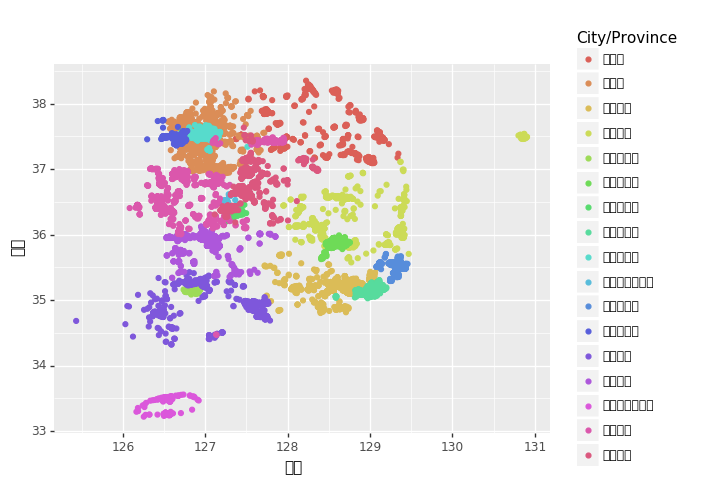

<ggplot: (30490308251)>

In [64]:
(ggplot(park_loc_notnull)
 + aes(x='경도', y='위도', color='City/Province')
 + geom_point()
 + theme(text=element_text(family='GungSuh'))
)